In [2]:
from __future__ import print_function, division
import sys

sys.path.append("..")
# General Imports
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split
from PIL import Image

# Torch import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.utils as vutils
from torch.optim import Adam
import torch.utils.data as data
import torchvision.datasets as dsets

# Torchgan Imports
import torchgan.models as models
import torchgan.losses as losses
from torchgan.trainer import Trainer

from model_DCGAN import AdversarialAutoencoderDiscriminator, AdversarialAutoencoderGenerator
from loss import AdversarialAutoencoderGeneratorLoss,AdversarialAutoencoderDiscriminatorLoss




# Define the lookup table from class to idx

In [3]:
class TwoWayDict(dict):
    def __setitem__(self, key, value):
        # Remove any previous connections with these values
        if key in self:
            del self[key]
        if value in self:
            del self[value]
        dict.__setitem__(self, key, value)
        dict.__setitem__(self, value, key)

    def __delitem__(self, key):
        dict.__delitem__(self, self[key])
        dict.__delitem__(self, key)

    def __len__(self):
        """Returns the number of connections"""
        return dict.__len__(self) // 2

DATA_FOLDER = "/data/data/GTData/OGDefectLibrary/Defectnewcrop"
class_to_idx = TwoWayDict()
for class_idx, class_folder in enumerate(os.listdir(DATA_FOLDER)):
    # folder name will be assigned as the name of the class while the idx is assigned to it by the order of the directories are listed
    class_to_idx[class_folder] = class_idx
    
# Class to idx now becomes a 1-to-1 map from class names to their idx so it's easy to use
for i in range(14):
    print(i,class_to_idx[i])
#print(class_to_idx['L63_OVerfill_w'])

0 L63_OVerfill_w
1 L99_PassWear_Ing
2 L93_Crack_B
3 T61_Chipmark_White
4 L91_SS_Gouge_White
5 L94_Linear_Thin
6 L70_Tdn_Lite
7 L97_WhiteMark_Ign
8 L90_SS_Gouge_Dark
9 L60_Overfill_Lite
10 T90_Burst
11 L64_Overfill_b
12 L71_Tdn_Heavy
13 T60_Chipmark_Dark


# Define the lookup table that will go into the PyTorch dataset

In [4]:
file_lookup = {"image_path": [], "class_idx": []}

for root, dir, files in os.walk(DATA_FOLDER):
    for file in files:
        if file.lower().endswith(".png") or file.lower().endswith(".jpg"):
            file_lookup["image_path"].append(os.path.join(root, file))
            file_lookup["class_idx"].append(class_to_idx[os.path.split(root)[-1]])
file_lookup = pd.DataFrame(file_lookup)
print(file_lookup.sample(5))
print()
print(file_lookup.iloc[0,1])
print(file_lookup.class_idx.unique())

                                             image_path  class_idx
352   /data/data/GTData/OGDefectLibrary/Defectnewcro...          4
95    /data/data/GTData/OGDefectLibrary/Defectnewcro...          1
126   /data/data/GTData/OGDefectLibrary/Defectnewcro...          1
1142  /data/data/GTData/OGDefectLibrary/Defectnewcro...         13
758   /data/data/GTData/OGDefectLibrary/Defectnewcro...          8

0
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


# Define the RollingDataset

In [5]:
class RollingDataset(Dataset):
    """Rollingdataset."""

    def __init__(self, lookup, transform=None):
        """
        Args:
            lookup (pd.DataFrame): 
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.lookup = lookup
        self.transform = transform

    def __len__(self):
        return len(self.lookup)

    def __getitem__(self, idx):
        img_path = self.lookup.image_path[idx]
        label = self.lookup.class_idx[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)
        
        return image, label

## Things we can do with `file_lookup`

### Boilerplate

In [6]:
# common basic transforms for plotting
basic_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.type(torch.FloatTensor))
])

### Subset by class
This example show how to subset the entire dataset and make a new RollingDataset out of it. As an example, we will only get the class whose class_idx is 0.

In [7]:
def subset_classes(file_lookup, classes_to_subset):
    new_lookup = file_lookup.copy()
    new_lookup = new_lookup[new_lookup["class_idx"].isin(classes_to_subset)]
    new_lookup = new_lookup.reset_index(drop=True)
    return new_lookup



### Sampling
we can sample the data by size or fraction, stratified or regular, using sklearn's `train_test_split`


In [8]:
def train_test_split_reset_index(file_lookup):
    X = file_lookup.copy()
    y = file_lookup.class_idx.copy()
    lookup_train, lookup_test = train_test_split(X, stratify=y)
    return lookup_train.reset_index(drop=True), lookup_test.reset_index(drop=True)

lookup_train, lookup_test = train_test_split_reset_index(file_lookup.copy())

train_counts = lookup_train.groupby(["class_idx"]).count()
test_counts = lookup_test.groupby(["class_idx"]).count()

print("Types of Anomaly\n")
for i in range(14):
    print(i,class_to_idx[i])
    
print("\nTrain sample count by class: (N={})\n".format(train_counts.sum().image_path))
print(train_counts)
print("\nTest sample count by class:(N={})\n".format(test_counts.sum().image_path))
print(test_counts)
print("\nRatios kept same through stratify:")
print(test_counts / train_counts)

Types of Anomaly

0 L63_OVerfill_w
1 L99_PassWear_Ing
2 L93_Crack_B
3 T61_Chipmark_White
4 L91_SS_Gouge_White
5 L94_Linear_Thin
6 L70_Tdn_Lite
7 L97_WhiteMark_Ign
8 L90_SS_Gouge_Dark
9 L60_Overfill_Lite
10 T90_Burst
11 L64_Overfill_b
12 L71_Tdn_Heavy
13 T60_Chipmark_Dark

Train sample count by class: (N=879)

           image_path
class_idx            
0                  69
1                  56
2                  14
3                  86
4                  58
5                  79
6                 100
7                  54
8                  67
9                  32
10                 72
11                 56
12                 41
13                 95

Test sample count by class:(N=294)

           image_path
class_idx            
0                  23
1                  19
2                   4
3                  29
4                  20
5                  26
6                  34
7                  18
8                  22
9                  11
10                 24
11            

### Subset normal class, then create train-val-test split

In [9]:
import pickle
basic_transform = transforms.Compose([
    transforms.RandomResizedCrop(50,scale=(0.9, 1.0), ratio=(0.75, 1.3333333333333333)),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - x.min())/(x.max()-x.min())),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Lambda(lambda x: x.type(torch.FloatTensor))
                                 ])

lookups = pickle.load( open( "save_lookups.pkl", "rb" ) )



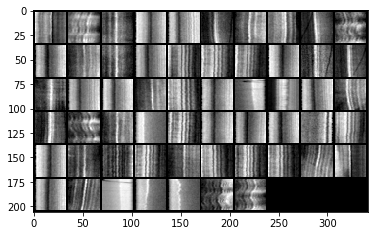

In [10]:
train_rolling_dataset = RollingDataset(lookups["normal"]["train"], basic_transform)
train_dataloader = DataLoader(train_rolling_dataset, batch_size=256, shuffle=True)

valid_rolling_dataset = RollingDataset(lookups["normal"]["valid"], basic_transform)
valid_dataloader = DataLoader(valid_rolling_dataset, batch_size=256, shuffle=True)
batch_X, batch_y = next(iter(valid_dataloader))
batch_X = (batch_X - batch_X.min())/(batch_X.max()-batch_X.min())
plt.imshow(np.transpose(vutils.make_grid(batch_X,nrow=10), [1,2,0]))



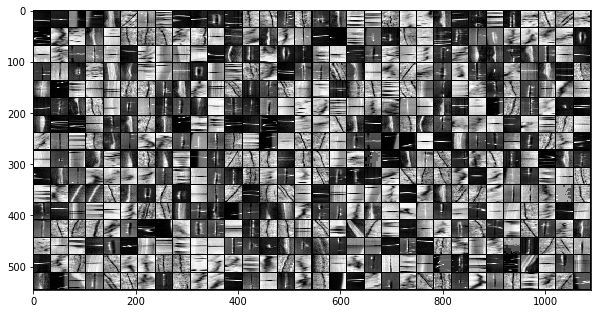

In [11]:
#anomaly_class_idx = [1,5,10,4,12][1,2,5,6,7,10,13]
anomaly_class_idx = [2,3,4,5,6,7,8,10,12]
lookups["anomaly"] = subset_classes(file_lookup, anomaly_class_idx)
test_rolling_dataset = RollingDataset(lookups["anomaly"], basic_transform)
test_dataloader = DataLoader(test_rolling_dataset, batch_size=512, shuffle=True)

batch_X, batch_y = next(iter(test_dataloader))
batch_X = (batch_X - batch_X.min())/(batch_X.max()-batch_X.min())
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(vutils.make_grid(batch_X,nrow=32), [1,2,0]))


In [20]:
losses = [AdversarialAutoencoderGeneratorLoss(),AdversarialAutoencoderDiscriminatorLoss()]
encoding_dims = 5
network = {
        'generator': {
            'name': AdversarialAutoencoderGenerator,
            'args': {
                'encoding_dims': encoding_dims,
                'input_size': 32,
                'input_channels': 1,
                'step_channels':16

            },
            'optimizer': {
                'name': Adam,
                'args': {
                    'lr': 0.002,
                    'betas': (0.5, 0.999)
                }
            }
        },
        'discriminator': {
            'name': AdversarialAutoencoderDiscriminator,
            'args': {
                'input_dims': encoding_dims,
            },
            'optimizer': {
                'name': Adam,
                'args': {
                    'lr': 0.0002,
                    'betas': (0.5, 0.999)
                }
            }
        }
}
trainer = Trainer(network, losses, sample_size=64, epochs=5000, device=torch.device('cuda:0'),log_dir='runs_circle')



In [22]:
trainer.load_model('model/gan4.model')

Loading Model From 'model/gan4.model'


In [23]:
it = iter(valid_dataloader)
RE_mean_all = np.zeros(10000)
T2_all = np.zeros(42)
D_all =  np.zeros(42)
self = trainer.generator
real_batch = next(it)
x = real_batch[0].cuda()
encoding = self.encoder(x)
encoding = self.encoder_fc(encoding.view(-1, encoding.size(1) * encoding.size(2) * encoding.size(3)))
code_z=(encoding)
T2 = torch.sum(torch.pow(code_z,2),1)
noise = self.decoder_fc(code_z)
noise = noise.view(-1, noise.size(1), 1, 1)
recon = self.decoder(noise)
RE = torch.sum(torch.sum(torch.sum(torch.pow(recon[:,:,:,:]-x[:,:,:,:],2),3),2),1)/32/32
dgz = trainer.discriminator(code_z)

with torch.no_grad():
    T2_all = T2.cpu().numpy()
    RE_mean_all = RE.cpu().numpy()
    D_all = dgz.squeeze().cpu().numpy()
code_z_normal=code_z.cpu().data.numpy()

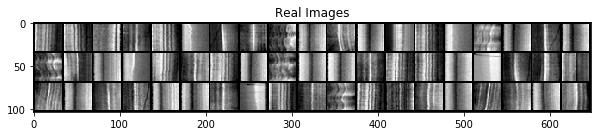

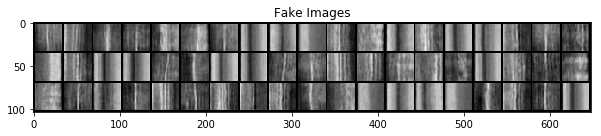

In [26]:
batch_X, batch_y = next(iter(valid_dataloader))
batch_X = (batch_X - batch_X.min())/(batch_X.max()-batch_X.min())

plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(vutils.make_grid(batch_X,nrow=19), [1,2,0]))
plt.title("Real Images")
plt.show()

itest = iter(valid_dataloader)

real_batch = next(itest)
x = real_batch[0].cuda()
encoding = self.encoder(x)
encoding = self.encoder_fc(encoding.view(-1, encoding.size(1) * encoding.size(2) * encoding.size(3)))
code_z=(encoding)
T2 = torch.sum(torch.pow(code_z,2),1)
noise = self.decoder_fc(code_z)
noise = noise.view(-1, noise.size(1), 1, 1)
recon = self.decoder(noise)

RE = torch.sum(torch.sum(torch.sum(torch.pow(recon[:,:,:,:]-x[:,:,:,:],2),3),2),1)/32/32
dgz = trainer.discriminator(code_z)

recon_image=recon.data.cpu()
recon_image = (recon_image - recon_image.min())/(recon_image.max()-recon_image.min())

plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(vutils.make_grid(recon_image,nrow=19), [1,2,0]))
plt.title("Fake Images")
plt.show()



In [27]:
itest = iter(test_dataloader)

real_batch = next(itest)
x = real_batch[0].cuda()
encoding = self.encoder(x)
encoding = self.encoder_fc(encoding.view(-1, encoding.size(1) * encoding.size(2) * encoding.size(3)))
code_z=torch.tanh(encoding)
T2 = torch.sum(torch.pow(code_z,2),1)
noise = self.decoder_fc(code_z)
noise = noise.view(-1, noise.size(1), 1, 1)
recon = self.decoder(noise)
RE = torch.sum(torch.sum(torch.sum(torch.pow(recon[:,:,:,:]-x[:,:,:,:],2),3),2),1)/32/32
dgz = trainer.discriminator(code_z)

with torch.no_grad():
    T2_all_test = T2.cpu().numpy()
    RE_mean_all_test = RE.cpu().numpy()
    D_all_test = dgz.squeeze().cpu().numpy()



In [29]:
RE_res = RE_mean_all_test > np.percentile(RE_mean_all,99.5)
T2_res = T2_all_test > np.percentile(T2_all,99.75)
D_res = D_all_test > np.percentile(D_all,99.75)

all_res = np.logical_or(RE_res,D_res)
nsample = RE_mean_all_test.shape[0]

# Accuracy of the MODEL

In [30]:
Qarr97=str(np.sum(RE_res)/nsample)
T2arr97=str(np.sum(T2_res)/nsample)
h=str(np.sum(all_res)/nsample)

print("Cross_Entropy:"," ".join(Qarr97))
print("T2arr97      :"," ".join(T2arr97))
print("h            :"," ".join(h))

Cross_Entropy: 0 . 9 6 2 9 6 2 9 6 2 9 6 2 9 6 2 9
T2arr97      : 0 . 0
h            : 0 . 9 6 2 9 6 2 9 6 2 9 6 2 9 6 2 9


Detectibility of the mdoel: 0 . 9 6 2